# Perceptron Learning Rule

Last revision: Martin Melchior - 25.02.2021

In this exercise you implement a _Rosenblatt Perceptron_ and the _Perceptron Learning Rule_. Then you apply it to linearly separable data. 

In a first step, you apply it to a dummy test data set, a **low-dimensional dataset** that is generated on the fly. And you can convince yourself that your system is properly implemented and has found the separating line. 

In a second (optional) part, you can apply it to a somewhat more advanced dataset, the **lightweight MNIST dataset** which consists of small (8x8) images, i.e. 64 dimensional arrays. Here, the linear separability can no longer be easily visualized. 

Some emphasis should be given to properly handle numpy arrays. These will be much more extensively used in upcoming exercises of later weeks. So, we recommend to take a serious glance at them.


## Step 1: Low-Dimensional Dataset 

### Prepare Dataset
Instead of providing a fixed input dataset, we here generate it randomly.
For easier comparison, we want to make sure that the same data is produced. Therefore, we set a random seed (set to 1 below).

The data will be generated in form of a 2d array, the first index enumerating the dimensions (rows, in the 2d case index 0 and 1), the second enumerating the samples (columns). 

Furthermore, we provide a suitable plotting utility that allows you to inspect the generated data.

In [1]:
import numpy as np

def prepare_data(m,m1,a,s,width=0.6,eps=0.5, seed=1):
    """
    Generates a random linearly separable 2D test set and associated labels (0|1).
    The x-values are distributed in the interval [-0.5,0.5]. 
    With the parameters a,s you can control the line that separates the two classes. 
    This turns out to be the line with the widest corridor between the two classes (with width 'width').
    If the random seed is set, the set will always look the same for given input parameters. 
    
    Arguments:
    a -- y-intercept of the seperating line
    s -- slope of the separating line
    m -- number of samples
    m1 -- number of samples labelled with '1'
    width -- width of the corridor between the two classes
    eps -- measure for the variation of the samples in x2-direction
    
    Returns:
    x -- generated 2D data of shape (2,n)
    y -- labels (0 or 1) of shape (1,n)
    """
    np.random.seed(seed)
    idx = np.random.choice(m, m1, replace=False)
    y = np.zeros(m, dtype=int).reshape(1,m)
    y[0,idx] = 1
    
    x = np.random.rand(2,m).reshape(2,m) # random numbers uniformly distributed in [0,1]
    x[0,:]-= 0.5
    idx1 = y[0,:]==1
    idx2 = y[0,:]==0
    x[1,idx1] = (a+s*x[0,idx1]) + (width/2+eps*x[1,idx1])
    x[1,idx2] = (a+s*x[0,idx2]) - (width/2+eps*x[1,idx2])
    
    return x,y

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def line(a, s, n=100):
    """    
    Returns a line 2D array with x and y=a+s*x.
    
    Parameters:
    a -- intercept
    s -- slope
    n -- number of points
    
    Returns:
    2d array of shape (n,2) 
    """
    x = np.linspace(-0.5, 0.5, n)
    l = np.array([x,a+s*x]).reshape(2,n)
    return l

def plot(x, y, params_best=None, params_before=None, params_after=None, misclassified=None, selected=None):
    """
    Plot the 2D data provided in form of the x-array. 
    Use markers depending on the label ('1 - red cross, 0 - blue cross').
    Optionally, you can pass tuples with parameters for a line (a: y-intercept, s: slope) 
    * params_best: ideal separating line (green dashed) 
    * params: predicted line (magenta)
    Finally, you can also mark single points:
    * misclassified: array of misclassified points (blue circles)
    * selected: array of selected points (green filled circles)
    
    Parameters:
    x -- 2D input dataset of shape (2,n)
    y -- ground truth labels of shape (1,n)
    params_best -- parameters for the best separating line
    params -- any line parameters
    misclassified -- array of points to be marked as misclassified
    selected -- array of points to be marked as selected
    """
    idx1 = y[0,:]==1
    idx2 = y[0,:]==0
    plt.plot(x[0,idx1], x[1,idx1], 'r+', label="label 1")
    plt.plot(x[0,idx2], x[1,idx2], 'b+', label="label 0")    
    if not params_best is None:
        a = params_best[0]
        s = params_best[1]
        l = line(a,s)
        plt.plot(l[0,:], l[1,:], 'g--')
    if not params_before is None:
        a = params_before[0]
        s = params_before[1]
        l = line(a,s)
        plt.plot(l[0,:], l[1,:], 'm--')
    if not params_after is None:
        a = params_after[0]
        s = params_after[1]
        l = line(a,s)
        plt.plot(l[0,:], l[1,:], 'm-')
    if not misclassified is None:
        plt.plot(x[0,misclassified], x[1,misclassified], 'o', label="misclassified")
    if not selected is None:
        plt.plot(x[0,selected], x[1,selected], 'oy', label="selected")
        
    plt.legend()
    plt.show()


#### Generate and Plot the Data

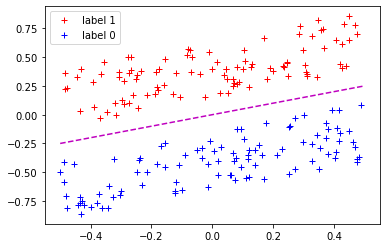

In [3]:
x,y = prepare_data(200,100,0,0.5,width=0.3,eps=0.5, seed=1)
plot(x, y, params_before=(0,0.5))

#### Parameters for the decision boundary

Here, you should implement a function that translates the weights vector $(w_1,w_2)$ and the bias $b$ into parameters of a straight line ( $x_2 = a + s \cdot x_1$ )

In [4]:
def lineparams(weight, bias):
    """
    Translates the weights vector and the bias into line parameters with a x2-intercept 'a' and a slope 's'.

    Parameters:
    weight -- weights vector of shape (1,2)
    bias -- bias (a number)
    
    Returns:
    a -- x2-intercept
    s -- slope of the line in the (x1,x2)-plane
    """
    ### START YOUR CODE ###
    w1, w2 = np.squeeze(weight)
    
    a = - bias / w2
    s = - w1 / w2
    ### END YOUR CODE ###
    return a,s

### Implement the Perceptron Learning Algorithm

by implementing the functions
* predict
* update
* select_datapoint
* train

Follow the descriptions of these functions.

In [5]:
def predict(x,w,b):
    """
    Computes the predicted value for a perceptron (single LTU).
    
    Parameters:
    x -- input dataset of shape (2,m)
    w -- weights vector of shape (1,2)
    b -- bias (a number)
    
    Returns:
    y -- prediction of a perceptron (single LTU) of shape (1,m)
    """
    ### START YOUR CODE ###
    y = (np.dot(w, x) + b) >= 0
    ### END YOUR CODE ###
    return y

def update(x,y,w,b,alpha=1.0):
    """
    Performs an update step in accordance with the perceptron learning algorithm.
    
    Parameters:
    x -- input data point of shape (2,1)
    y -- true label ('ground truth') for the specified point
    w -- weight vector of shape (1,2)
    b -- bias (a number)
    
    Returns:
    w1 -- updated weight vector
    b1 -- updated bias
    """
    ypred = predict(x,w,b)

    ### START YOUR CODE ###
    w1 = w - alpha * (ypred - y) * x
    b1 = b - alpha * (ypred - y)
    ### END YOUR CODE ###
    
    return w1, b1


def select_datapoint(x, y, w, b):
    """
    Identifies the misclassified data points and selects one of them.
    In case all datapoints are correctly classified None is returned. 

    Parameters:
    x -- input dataset of shape (2,m)
    y -- ground truth labels of shape (1,m)
    w -- weights vector of shape (1,2)
    b -- bias (a number)
    
    Returns:
    x1 -- one of the wrongly classified datapoint (of shape (2,1))
    y1 -- the associated true label
    misclasssified -- array with indices of wrongly classified datapoints or empty array
    """
    ypred = predict(x,w,b)
    wrong_mask = (ypred != y)[0]
    misclassified = np.where(wrong_mask)[0]
    if len(misclassified)>0:
        x1 = x[:,misclassified[0]]
        y1 = y[0,misclassified[0]]
        return x1, y1, misclassified
    return None, None, []

def train(weight_init, bias_init, x, y, alpha=1.0, debug=False, params_best=None, max_iter=1000):
    """
    Trains the perceptron (single LTU) for the given data x and ground truth labels y
    by using the perceptron learning algorithm with learning rate alpha (default is 1.0).
    The max number of iterations is limited to 1000.
    
    Optionally, debug output can be provided in form of plots with showing the effect 
    of the update (decision boundary before and after the update) provided at each iteration.    
    
    Parameters:
    weight_init -- weights vector of shape (1,2)
    bias_init -- bias (a number)
    x -- input dataset of shape (2,m)
    y -- ground truth labels of shape (1,m)
    alpha -- learning rate
    debug -- flag for whether debug information should be provided for each iteration
    params_best -- needed if debug=True for plotting the true decision boundary
    
    Returns:
    weight -- trained weights
    bias -- trained bias
    misclassified_counts -- array with the number of misclassifications at each iteration
    """
    weight = weight_init
    bias = bias_init
    iterations = 0
    misclassified_counts = [] # we track them to show how the system learned in the end 
    ### START YOUR CODE ###
    while iterations<=max_iter:
        # get the params before
        params_before = lineparams(weight, bias)
        
        # pick sample
        x_i, y_i, misclassified = select_datapoint(x, y, weight, bias)
        misclassified_counts.append(len(misclassified))
        
        # check if there are still missclassified samples
        if x_i is None and y_i is None:
            break
        
        # update parameters
        weight, bias = update(x_i, y_i, weight, bias, alpha)
        
        # update the iterations
        iterations += iterations
        
        if debug:
            params_after = lineparams(weight, bias)
            plot(x,y,
                 params_best=params_best, 
                 params_before=params_before, 
                 params_after=params_after, 
                 misclassified=misclassified, 
                 selected=np.array([misclassified[0]]))
    ### END YOUR CODE ###
        
    return weight, bias, misclassified_counts

#### Auxiliary Function

In [6]:
def weights_and_bias(a,s):
    """
    Computes weights vector and bias from line parameters x2-intercept and slope.
    """
    w1 = - s
    w2 = 1.0
    weight = np.array([w1,w2]).reshape(1,2)
    bias = - a
    return weight, bias

### Test Your Implementation

1/ Prepare the dataset by using the prepare_data function defined above and plot it. Use the parameters specified below (a=1, s=2, n=100, n1=50).

2/ Run the training with the default learning rate (alpha=1).
Paste the plots with the situation at the start and with the situation at the end of the training in a text document.
Paste also the start parameters (weight and bias) and trained parameters.

3/ Create a plot with the number of mis-classifications vs iteration.

#### 1/ Prepare the dataset

weight:  [[-2.  1.]]   bias:  -1


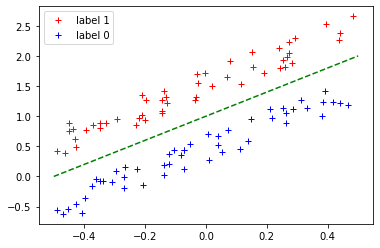

In [7]:
m = 100
m1 = 50
a = 1
s = 2
x,y = prepare_data(m,m1,a,s)

params_best = (a,s)
weight_best, bias_best = weights_and_bias(a, s)
print("weight: ", weight_best, "  bias: ", bias_best)
plot(x,y,params_best=params_best)

#### 2/ Run the training

Initial Params:  [[0. 1.]] 0
(0.0, -0.0)


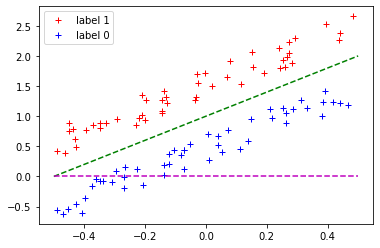

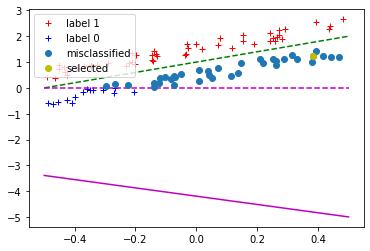

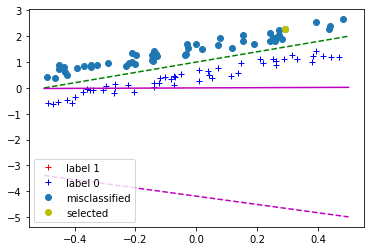

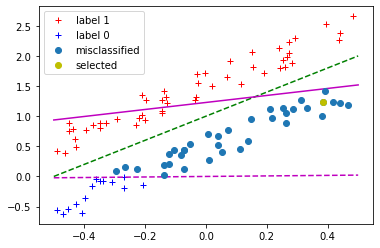

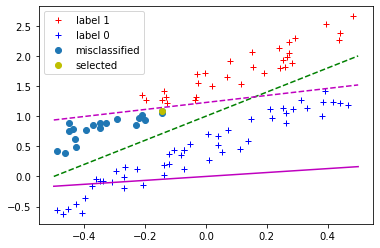

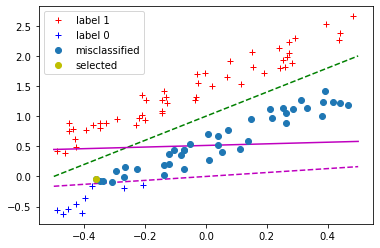

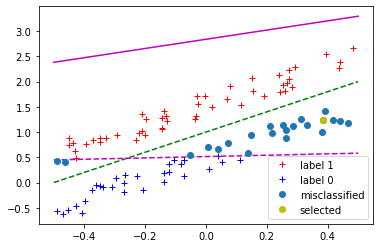

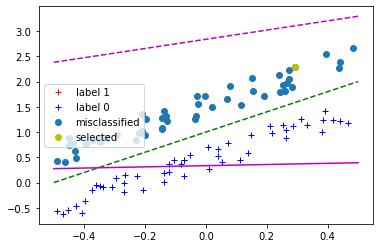

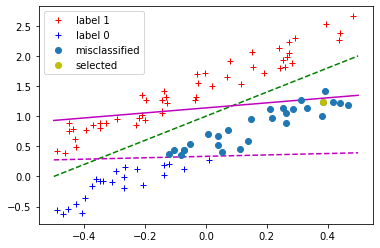

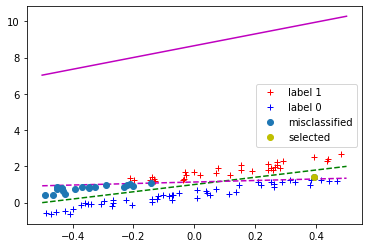

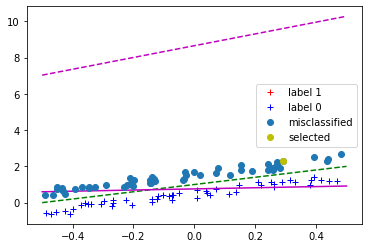

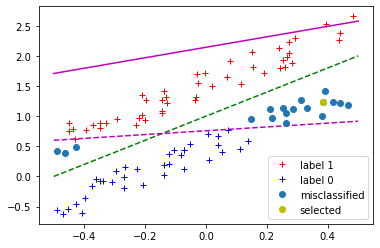

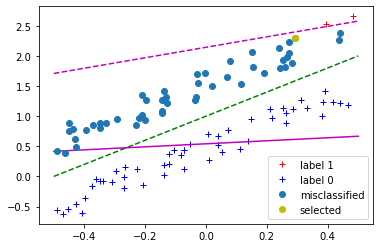

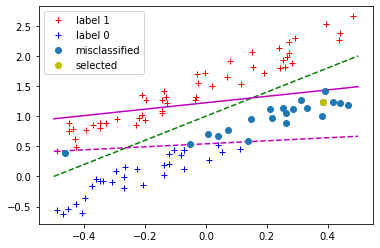

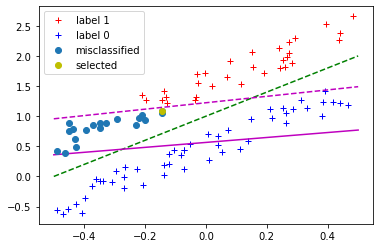

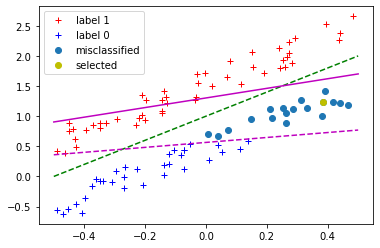

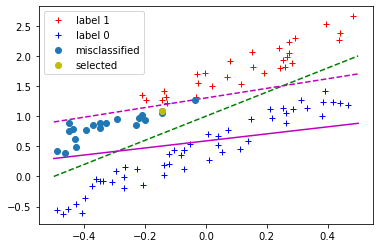

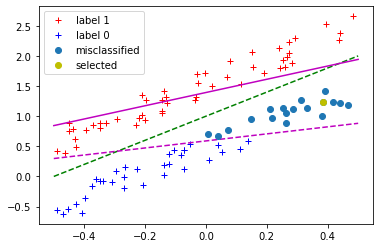

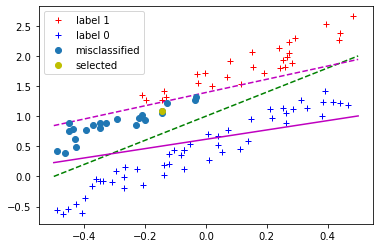

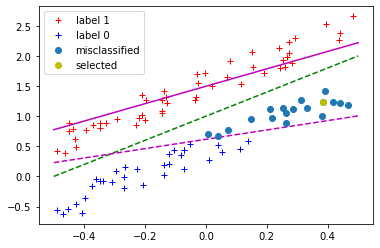

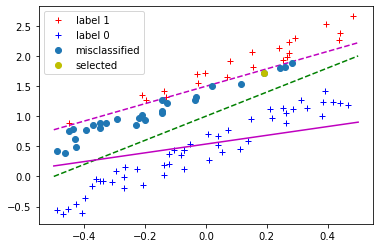

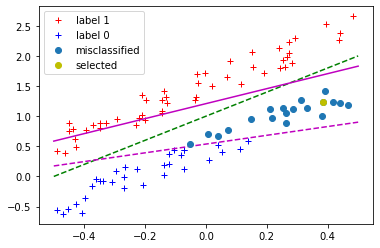

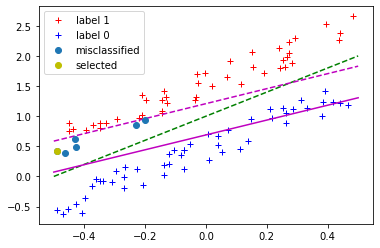

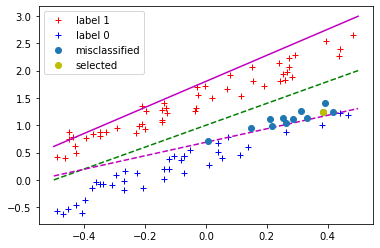

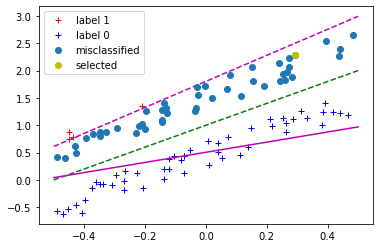

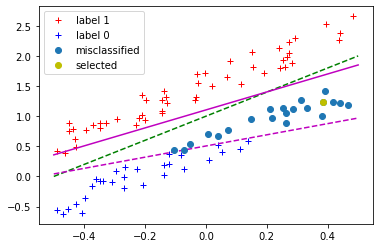

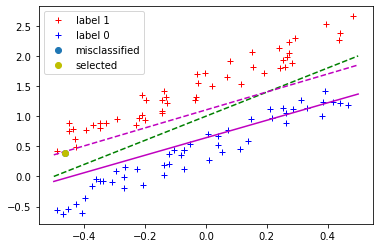

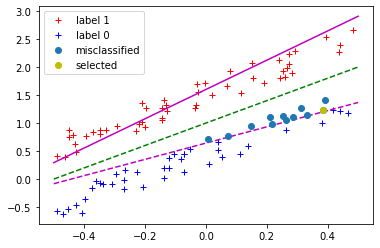

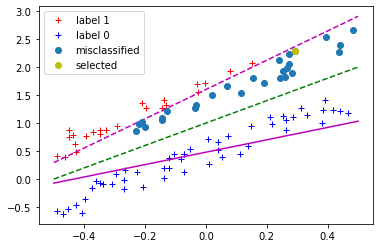

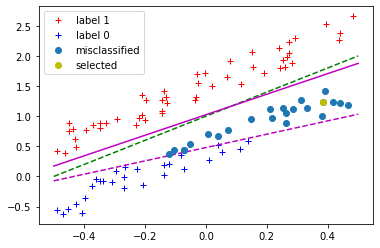

Iterations:  29
Trained Params:  [[-4.99046876  2.92867787]] [-3.]


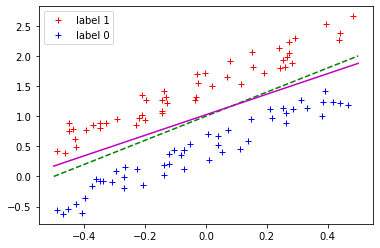

In [8]:
a1 = 0
s1 = 0
alpha = 1.0

weight1, bias1 = weights_and_bias(a1,s1)
print("Initial Params: ",weight1,bias1)
params = lineparams(weight1, bias1)
print(params)
plot(x,y,params_best, params)

#weight1,bias1,misclassified_counts = train(weight1, bias1, x, y)
weight1,bias1,misclassified_counts = train(weight1, bias1, x, y, debug=True, params_best=params_best)
params = lineparams(weight1, bias1)
print("Iterations: ", len(misclassified_counts)-1)
print("Trained Params: ", weight1,bias1)
plot(x,y, params_best=params_best, params_after=params)


#### 3/ Create the plot with the misclassifications per iteration

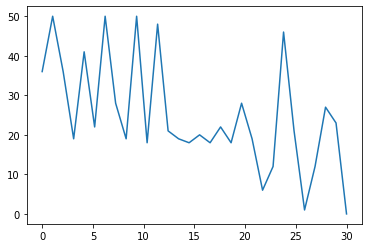

In [9]:
nit = len(misclassified_counts)
it = np.linspace(0,nit,nit)

plt.plot(it, misclassified_counts)

### Summary 
The LTU converges after 29 iterations to a feasible solution. However, this solution is not the same as the green dotted decision boundary, but still, one that is suitable to differentiate the two classes. Further, it can be seen that the algorithm first tries to find the correct intersect and then only in the last few steps optimizes the slope, but this is heavily dependant on the selected data point.

## Step 2: Lightweight MNIST Dataset (optional)
The following method allows to load the dataset. It generates two sets of (x,y)-pairs where
* x are 64-dim arrays corresponding to the grayscale values of a 8x8 pixel image
* y are numbers indicating the digit (1 indicating a first selected digit and 0 a second selected digit).

The first of the two sets is then used for training the perceptron model, i.e. determining the weights and bias. The second is used for testing.

### Prepare Dataset
See the doc string of the method below for further details.

In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

def load_data(selected_digits):
    """
    Loads the Lightweight MNIST dataset from sklearn, filters the data for two digits (two distinct label values between 0 and 9) 
    and split the resulting dataset of (x,y)-pairs (where x are 64 dimensional arrays corresponding to the grayscale values of a 
    8x8 pixel image) in a two distinct subsets: one will be used for tuning the weights of the learning algorithm, the second for 
    testing it. The samples with the first digit will be associated with a y-value equal to 1, the second with a y-value equal to 0.  
    
    Parameters:
    selected_digits -- tuple with two distinct digit
    
    Returns:
    x_train -- x-values of the subset of images used for training (containing only selected digits)
    x_test -- x-values of the subset of images used for testing (containing only selected digits)
    y_train -- y-values of the subset of labels (associated with the images) used for training ('1' indicating that the associated 
    image depicts the first selected digit, '0' indicating that the associated image depicts the second selected digit)
    y_test -- y-values as above but used for testing
    """
    # load digits
    digits = load_digits()
    x = digits.data.T
    y = digits.target.reshape(1,x.shape[1])
    
    # select two given digits - will the train a model that learns to differentiate between the two
    digit1 = selected_digits[0]
    digit2 = selected_digits[1]
    mask1 = y[0,:]==digit1
    mask2 = y[0,:]==digit2
    x1 = x[:,mask1 | mask2]
    y1 = y[0,mask1 | mask2]
    y1 = y1.reshape(1,y1.size)
    
    ## Define the label for the binary classification
    mask1 = y1[0,:]==digit1
    mask2 = y1[0,:]==digit2
    y1[0,mask1] = 1
    y1[0,mask2] = 0

    print("Selecting %i images with digit %i and %i images with digit %i"%(np.sum(mask1),digit1,np.sum(mask2),digit2))
    
    x_train, x_test, y_train, y_test = train_test_split(x1.T, y1.T, test_size=0.20, random_state=1)

    # reshape - transpose back the output obtained from the train_test_split-function
    x_train = x_train.T
    x_test = x_test.T
    m_train = x_train.shape[1]
    m_test = x_test.shape[1]
    y_train=y_train.reshape(1,m_train)
    y_test=y_test.reshape(1,m_test)

    print("Shape training set: ", x_train.shape, y_train.shape)
    print("Shape test set:     ", x_test.shape, y_test.shape)
    
    return x_train, x_test, y_train, y_test    

### Implement the Perceptron Learning Algorithm

Adjust the implementation with similar functions as above - here denoted by
* predict_digit
* update_weights
* select_digit
* train_weights

to cope with the different digits dataset. Specifically, check that you get the shapes of the numpy arrays correct.

In [11]:
def predict_digit(x,w,b):
    """
    Computes the predicted value for a perceptron (single LTU).
    
    Parameters:
    x -- input dataset of shape (n,m)
    w -- weights vector of shape (1,n)
    b -- bias (a number)
    
    Returns:
    y -- prediction of a perceptron (single LTU) of shape (1,m)
    """
    ### START YOUR CODE ###
    y = (np.dot(w, x) + b) >= 0
    ### END YOUR CODE ###
    return y

def update_weights(x,y,w,b,alpha=1.0):
    """
    Performs an update step in accordance with the perceptron learning algorithm.
    
    Parameters:
    x -- input data point of shape (n,1)
    y -- true label ('ground truth') for the specified point
    w -- weight vector of shape (1,n)
    b -- bias (a number)
    
    Returns:
    w1 -- updated weight vector
    b1 -- updated bias
    """
    ### START YOUR CODE ###
    y_pred = predict_digit(x,w,b)
    w1 = w - alpha * (y_pred - y) * x
    b1 = b - alpha * (y_pred - y)
    ### END YOUR CODE ###
    return w1, b1


def select_digit(x, y, w, b):
    """
    Identifies the misclassified data points and selects one of them.
    In case all datapoints are correctly classified None is returned. 

    Parameters:
    x -- input dataset of shape (n,m)
    y -- ground truth labels of shape (1,m)
    w -- weights vector of shape (1,n)
    b -- bias (a number)
    
    Returns:
    x1 -- one of the wrongly classified datapoint (of shape (n,1))
    y1 -- the associated true label
    misclasssified -- array with indices of wrongly classified datapoints or empty array
    """
    ### START YOUR CODE ###
    y_pred = predict_digit(x,w,b)
    wrong_mask = (y_pred != y)[0]
    misclassified = np.where(wrong_mask)[0]
    if len(misclassified)>0:
        x1 = x[:,misclassified[0]]
        y1 = y[0,misclassified[0]]
        return x1, y1, misclassified
    return None, None, []
    ### END YOUR CODE ###

def train_weights(weight_init, bias_init, x, y, alpha=1.0, max_iter=1000):
    """
    Trains the perceptron (single LTU) for the given data x and ground truth labels y
    by using the perceptron learning algorithm with learning rate alpha (default is 1.0).
    The max number of iterations is limited to 1000.
    
    Optionally, debug output can be provided in form of plots with showing the effect 
    of the update (decision boundary before and after the update) provided at each iteration.    
    
    Parameters:
    weight_init -- weights vector of shape (1,n)
    bias_init -- bias (a number)
    x -- input dataset of shape (n,m)
    y -- ground truth labels of shape (1,m)
    alpha -- learning rate
    debug -- flag for whether debug information should be provided for each iteration
    
    Returns:
    weight -- trained weights
    bias -- trained bias
    misclassified_counts -- array with the number of misclassifications at each iteration
    """
    ### START YOUR CODE ###
    weight = weight_init
    bias = bias_init
    iterations = 0
    misclassified_counts = [] # we track them to show how the system learned in the end
    while iterations<=max_iter:
        # pick sample
        x_i, y_i, misclassified = select_digit(x, y, weight, bias)
        misclassified_counts.append(len(misclassified))
        
        # check if there are still missclassified samples
        if x_i is None and y_i is None:
            break
        
        # update parameters
        weight, bias = update_weights(x_i, y_i, weight, bias, alpha)
        
        # update the iterations
        iterations += iterations
    ### END YOUR CODE ###
    return weight, bias, misclassified_counts

### Load Data and Run Training

With the digits (1,7) the perceptron learning algorithm should converge. If you are interested, check whether there are digit pairs fro which it does not converge.

In [12]:
selected_digits = (1,7)
x_train, x_test, y_train, y_test = load_data(selected_digits)

Selecting 182 images with digit 1 and 179 images with digit 7
Shape training set:  (64, 288) (1, 288)
Shape test set:      (64, 73) (1, 73)


#### Inspect two sample images  

0
1


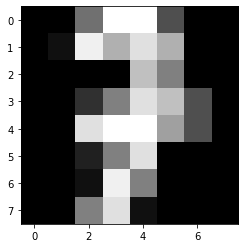

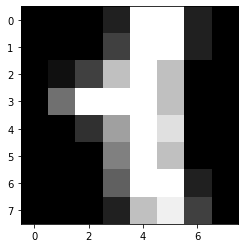

In [13]:
image = x_train[:,17]
plt.figure(1)
plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
print(y_train[0,17])
image = x_test[:,25]
plt.figure(2)
plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
print(y_train[0,25])

#### Train

In [14]:
weights = np.zeros((1,64),dtype=float)
bias = 0.0
weight1,bias1,misclassified_counts = train_weights(weights, bias, x_train, y_train)

#### Test

In [15]:
y_pred = predict_digit(x_train,weight1,bias1)
print(len(np.where(y_pred[0,:] != y_train[0,:])[0]))
y_pred = predict_digit(x_test,weight1,bias1)
print(len(np.where(y_pred[0,:] != y_test[0,:])[0]))

0
0


### Visualize how training has progressed

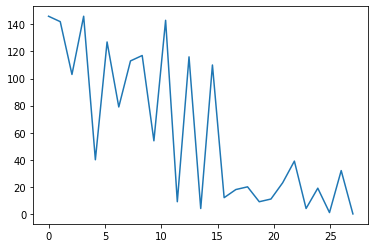

In [16]:
nit = len(misclassified_counts)
it = np.linspace(0,nit,nit)

plt.plot(it, misclassified_counts)

### Check all the (distinct) digit pairs

In [17]:
import itertools

available_digits = list(range(10))
for digit_1, digit_2 in itertools.combinations(available_digits, 2):
    # select the two digits to differentiate
    selected_digits = (digit_1, digit_2)
    print('Measuring performance for digits: {0}, {1}'.format(digit_1, digit_2))
    x_train, x_test, y_train, y_test = load_data(selected_digits)
    # train the LTU
    weights = np.zeros((1,64),dtype=float)
    bias = 0.0
    weight1,bias1,misclassified_counts = train_weights(weights, bias, x_train, y_train)
    print('N. of iterations needed to converge: %s' % len(misclassified_counts))
    # measure performance
    y_train_pred = predict_digit(x_train,weight1,bias1)
    y_test_pred = predict_digit(x_test,weight1,bias1)
    train_err = len(np.where(y_train_pred[0,:] != y_train[0,:])[0])
    test_err = len(np.where(y_test_pred[0,:] != y_test[0,:])[0])
    print('Train err: {0}, Test err: {1}'.format(train_err, test_err))
    print('-' * 20)

Measuring performance for digits: 0, 1
Selecting 178 images with digit 0 and 182 images with digit 1
Shape training set:  (64, 288) (1, 288)
Shape test set:      (64, 72) (1, 72)
N. of iterations needed to converge: 11
Train err: 0, Test err: 0
--------------------
Measuring performance for digits: 0, 2
Selecting 178 images with digit 0 and 177 images with digit 2
Shape training set:  (64, 284) (1, 284)
Shape test set:      (64, 71) (1, 71)
N. of iterations needed to converge: 11
Train err: 0, Test err: 0
--------------------
Measuring performance for digits: 0, 3
Selecting 178 images with digit 0 and 183 images with digit 3
Shape training set:  (64, 288) (1, 288)
Shape test set:      (64, 73) (1, 73)
N. of iterations needed to converge: 7
Train err: 0, Test err: 0
--------------------
Measuring performance for digits: 0, 4
Selecting 178 images with digit 0 and 181 images with digit 4
Shape training set:  (64, 287) (1, 287)
Shape test set:      (64, 72) (1, 72)
N. of iterations needed 

Selecting 181 images with digit 4 and 174 images with digit 8
Shape training set:  (64, 284) (1, 284)
Shape test set:      (64, 71) (1, 71)
N. of iterations needed to converge: 43
Train err: 0, Test err: 1
--------------------
Measuring performance for digits: 4, 9
Selecting 181 images with digit 4 and 180 images with digit 9
Shape training set:  (64, 288) (1, 288)
Shape test set:      (64, 73) (1, 73)
N. of iterations needed to converge: 39
Train err: 0, Test err: 0
--------------------
Measuring performance for digits: 5, 6
Selecting 182 images with digit 5 and 181 images with digit 6
Shape training set:  (64, 290) (1, 290)
Shape test set:      (64, 73) (1, 73)
N. of iterations needed to converge: 22
Train err: 0, Test err: 0
--------------------
Measuring performance for digits: 5, 7
Selecting 182 images with digit 5 and 179 images with digit 7
Shape training set:  (64, 288) (1, 288)
Shape test set:      (64, 73) (1, 73)
N. of iterations needed to converge: 24
Train err: 0, Test err

### Summary
The LTU converges for all distinct digit combination under the max iterations (1000). The results from the LTU fitted on different digit combinations shows that there is a difference in the performance depending on the chosen combination. The results also show that the model can fit the train set perfectly in all cases but cannot generalize to unseen ones in some of them.